In [1]:
%reload_ext autoreload
%autoreload 2

In [38]:
from Scratch import metadata_loader
import numpy as np
from tqdm import tqdm

DEVICE = "ibm_sherbrooke"
LOGICAL = str(0)
XBASIS = False
ROUNDS = 10

state = "X" if XBASIS else "Z"
state += LOGICAL
print(f"state = {state}")


# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md[md["descr"] == 'subset RepCodes']
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]
md = md[md["xbasis"] == XBASIS]
md = md[md["rounds"] == ROUNDS]

md = md[md['notebook_name']=='Sherbrooke_RepCodes_jobs']

# md = md[0:1]
print("shape:", md.shape)
md[:2]


state = Z0
shape: (40, 18)


,creation_date,notebook_name,backend_name,job_id,tags,meas_level,shots,num_qubits,job_status,execution_date,code,distance,rounds,logical,descr,resets,xbasis,path_info
4246,2024-03-23 09:24:23.431000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqz93dxs9z7g008dny3g,"[Subset 52, 10 rounds, 0 log, xbasis=False]",1.0,6525.0,NaN,JobStatus.DONE,2024-03-23 10:20:19.544059+01:00,RepetitionCodeCircuit,52,10,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.007733045348037, 'min_ga..."
4245,2024-03-23 09:24:20.868000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqz93d5czq6g0081h1vg,"[Subset 52, 10 rounds, 0 log, xbasis=False]",1.0,6525.0,NaN,JobStatus.DONE,2024-03-23 10:19:41.529823+01:00,RepetitionCodeCircuit,52,10,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.007733045348037, 'min_ga..."


In [39]:
from result_saver import SaverProvider

provider = SaverProvider()

In [40]:
md_loc = 0

job_id = md.iloc[md_loc]["job_id"]
job = provider.retrieve_job(job_id) 

execution_date = job.result().date
memory = job.result().get_memory()

print(f"Execution date: {execution_date}")

Execution date: 2024-03-23 10:20:19.544059+01:00


In [41]:
# assert md_loc == -1
# for id in range(-5, -1):
#     job = provider.retrieve_job(md.iloc[id]["job_id"])
#     memory = np.vstack([memory, job.result().get_memory()])

assert md_loc == 0
for id in range(1, 5):
    job = provider.retrieve_job(md.iloc[id]["job_id"])
    memory = np.vstack([memory, job.result().get_memory()])

# Needed decoding objects

#### KDE

In [42]:
import numpy as np

_RESETS = False
SOFT_MUL = 0.5
T = md.iloc[md_loc]["rounds"]
d = md.iloc[md_loc]["distance"]

shots = md.iloc[md_loc]["shots"]

rel_error = 1

# KDE BANDWIDTHS
lin = [0.1, 0.7, 30]
num_points = 51
bandwidths = np.linspace(lin[0], lin[1], lin[2])
bandwidths = [0.6]

In [43]:
from soft_info import get_repcode_IQ_map
from soft_info import inv_qubit_mapping
from Scratch import load_calibration_memory
import cpp_soft_info
from datetime import datetime

all_memories, gmm_dict, msmt_err_dict = load_calibration_memory(provider, tobecalib_backend=DEVICE, 
                                                                other_date=execution_date, post_process=True,
                                                                double_msmt=False)
kde_dict = cpp_soft_info.get_KDEs(all_memories, bandwidths, relError=rel_error, absError=-1, num_points=num_points)

all_memories_PS, gmm_dict_PS, msmt_err_dict_PS = load_calibration_memory(provider, tobecalib_backend=DEVICE, 
                                                                other_date=execution_date, post_process=True,
                                                                double_msmt=True)

kde_dict_PS = cpp_soft_info.get_KDEs(all_memories_PS, bandwidths, relError=rel_error, absError=-1, num_points=num_points)

Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 09:20:51.751471+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 09:21:22.889460+00:00.


In [ ]:
# Get the layout of the last job (same as previous)
layout_des = job.deserialize_layout(job.initial_layouts()[0]) # only 1 layout
link_qubits = list(layout_des['link_qubit'].values())
code_qubits = list(layout_des['code_qubit'].values())

# Get the pSoft and countMat matrices
big_layout = link_qubits + code_qubits
inverted_q_map = inv_qubit_mapping(get_repcode_IQ_map(big_layout, synd_rounds=T))

pSoft, countMat = cpp_soft_info.iqConvertor(memory, inverted_q_map, kde_dict, rel_error, -1, handleOutliers=True)

#### KDE_PS

In [ ]:
pSoftPS, countMatPS = cpp_soft_info.iqConvertor(memory, inverted_q_map, kde_dict_PS, rel_error, -1, handleOutliers = True)

#### Gaussian

In [ ]:
from soft_info import gaussianIQConvertor

countMatG, pSoftG = gaussianIQConvertor(memory, inverted_q_map, gmm_dict)
print(pSoftG.shape[0]*pSoftG.shape[1])

19606070


In [ ]:
# post select high pSoftPS
print(pSoftPS.shape[0]*pSoftPS.shape[1])

pSoftPSPS = pSoftPS[pSoftPS != 0.5]
print(pSoftPSPS.shape[0])


19606070
19606070


In [ ]:
print(np.max(pSoftPS))
print(np.max(pSoft))

# print how many entries are bigger than 0.5
print(np.sum(pSoftPS > 0.5))
print(np.sum(pSoft > 0.5))

print()
print(np.sum(pSoftPS == 0))
print(np.sum(pSoft == 0))
print(np.sum(pSoftG == 0))

print(np.min(pSoftPS))
print(np.min(pSoft))
print(np.min(pSoftG))

0.49999831656888194
0.49999892369348925
0
0

0
0
0
5.524686476640185e-16
3.491437010285619e-15
8.321508194549665e-70


# Info about points with high ambiguity

In [ ]:
print(countMat.shape)
print(f"total number of entries: {countMat.shape[0]*countMat.shape[1]}")

# filter out where pSoft > 0.2 and < 0.3
low, high = 0.22, 0.33
mask = (pSoft > low) & (pSoft < high)
countHighAmbig = countMat[mask] 

# countHighAmbig = countMat[pSoft > 0.2]
print(f"shape of countHighAmbig: {countHighAmbig.shape}, proportion: {countHighAmbig.shape[0]/(countMat.shape[0]*countMat.shape[1])}")
print(f"sum of countHighAmbig: {np.sum(countHighAmbig)}, proportion of 1s: {np.sum(countHighAmbig)/countHighAmbig.shape[0]}")

(7535, 2602)
total number of entries: 19606070
shape of countHighAmbig: (555857,), proportion: 0.028351270805418934
sum of countHighAmbig: 268824, proportion of 1s: 0.483620787360778


In [ ]:
from soft_info import plot_IQ_data, plot_multiple_IQ_data

# Qubit per qubit ambiguity
# Plot qubit per qubit the ambigous points 

qubit = 3
low = 0.3
high = 0.5

# for qubit in sorted(inverted_q_map.keys()):
cols = inverted_q_map[qubit]
pSoft_sub = pSoft[:, cols]
pSoftPS_sub = pSoftPS[:, cols]
pSoftG_sub = pSoftG[:, cols]
countMat_sub = countMat[:, cols]
countMatPS_sub = countMatPS[:, cols]
mmr_sub = memory[:, cols]

mask = (pSoft_sub > low) & (pSoft_sub < high)
countHighAmbig = countMat_sub[mask]
print(f"sum of countHighAmbig: {np.sum(countHighAmbig)}, proportion of 1s: {np.sum(countHighAmbig)/countHighAmbig.shape[0]}")
print(f"Qubit {qubit}: mean pSoft: {np.mean(pSoft_sub)}, std pSoft: {np.std(pSoft_sub)}")

# plot_IQ_data(mmr_sub)
# plot_IQ_data(mmr_sub[mask])
# plot_multiple_IQ_data([mmr_sub, mmr_sub[mask]], legend_labels=["All data", f"Ambiguous data {low} < ps < {high}"], title=f"qubit {qubit}, device {DEVICE}, rounds {T}, distance {d}")



sum of countHighAmbig: 5991, proportion of 1s: 0.3028204609785685
Qubit 3: mean pSoft: 0.034625119685519117, std pSoft: 0.0957818816742667


18:14:11 Warning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 114


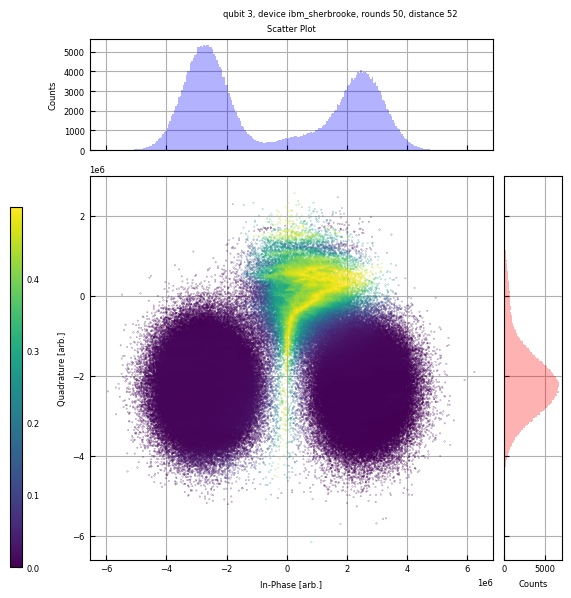

18:14:13 Warning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 114


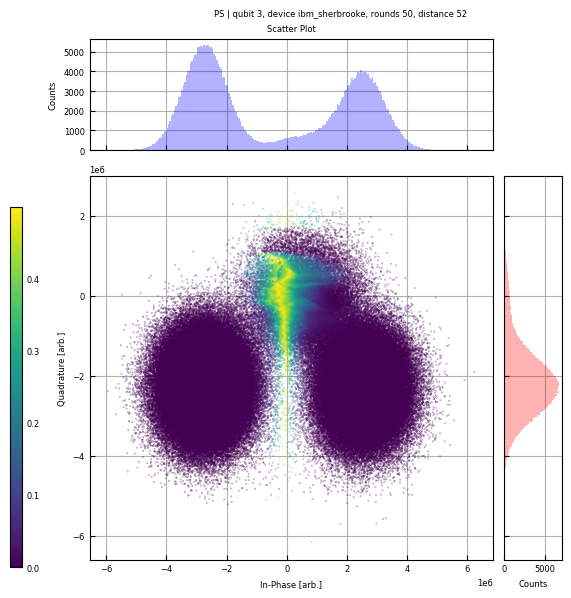

18:14:15 Warning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 114


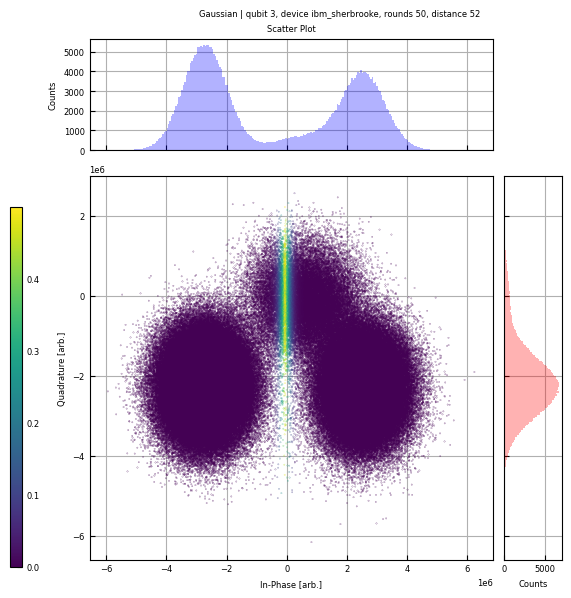

In [ ]:
from soft_info import plot_IQ_data_pSoft_cmap

plot_IQ_data_pSoft_cmap(mmr_sub, pSoft_sub, title=f"qubit {qubit}, device {DEVICE}, rounds {T}, distance {d}", figsize=(6, 6))
plot_IQ_data_pSoft_cmap(mmr_sub, pSoftPS_sub, title=f"PS | qubit {qubit}, device {DEVICE}, rounds {T}, distance {d}", figsize=(6, 6))
plot_IQ_data_pSoft_cmap(mmr_sub, pSoftG_sub, title=f"Gaussian | qubit {qubit}, device {DEVICE}, rounds {T}, distance {d}", figsize=(6, 6))



# State color plotter

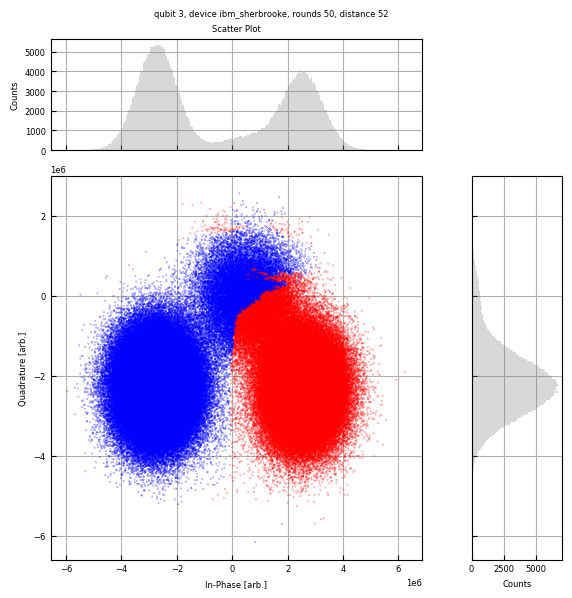

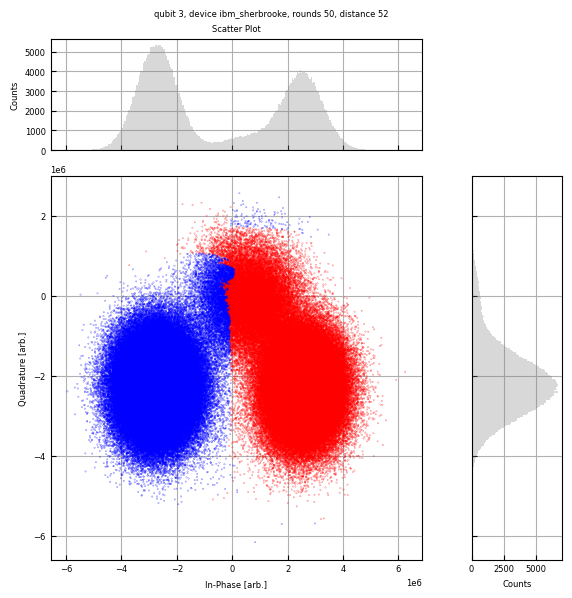

In [ ]:
from soft_info import plot_IQ_data_with_countMat

plot_IQ_data_with_countMat(mmr_sub, countMat_sub, title=f"qubit {qubit}, device {DEVICE}, rounds {T}, distance {d}", figsize=(6, 6))
plot_IQ_data_with_countMat(mmr_sub, countMatPS_sub, title=f"qubit {qubit}, device {DEVICE}, rounds {T}, distance {d}", figsize=(6, 6))

# Calibration data

18:11:38 Warning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 233


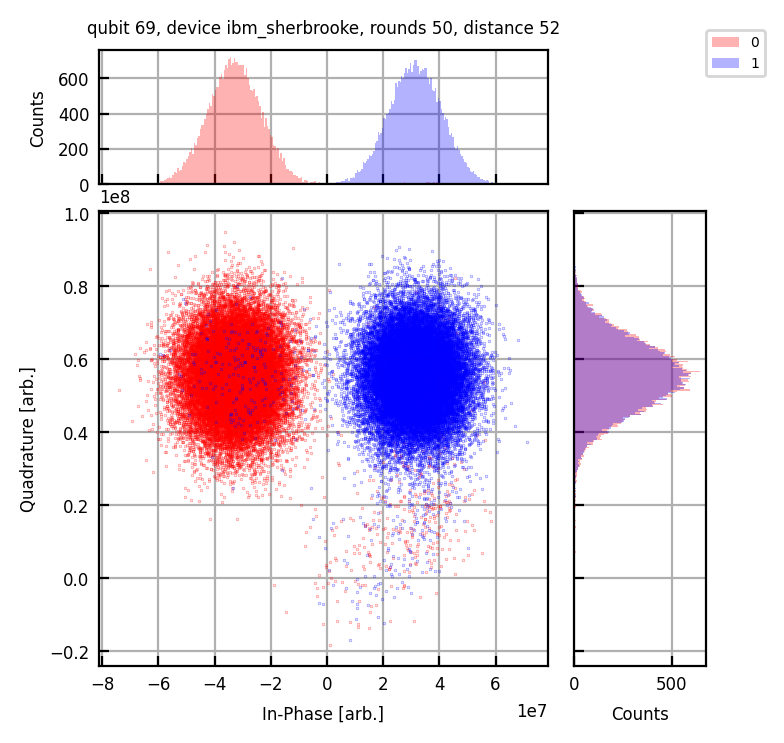

18:11:39 Warning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 233


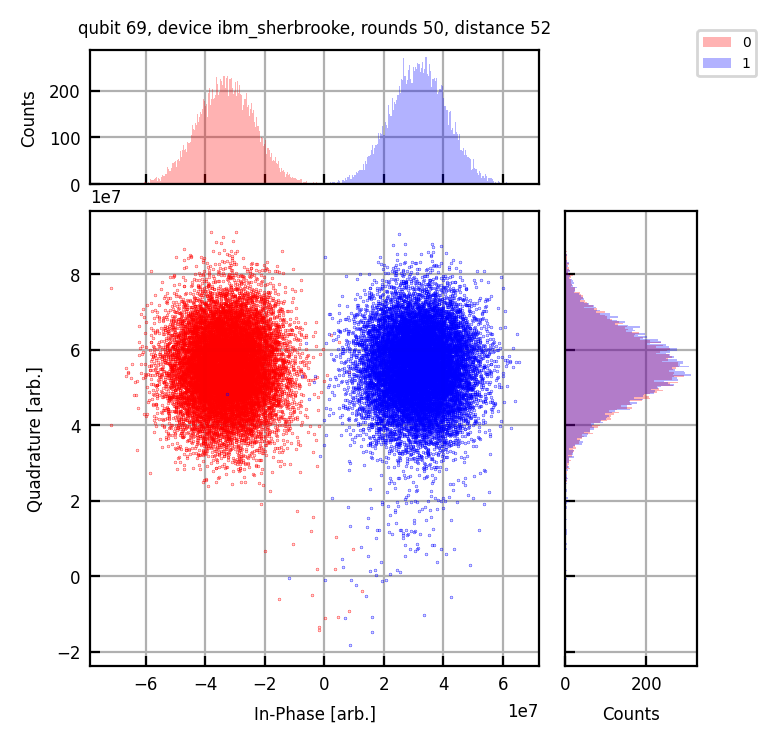

In [ ]:
plot_multiple_IQ_data([all_memories[qubit]['mmr_0'], all_memories[qubit]['mmr_1']], legend_labels=["0", "1"], title=f"qubit {qubit}, device {DEVICE}, rounds {T}, distance {d}")
plot_multiple_IQ_data([all_memories_PS[qubit]['mmr_0'], all_memories_PS[qubit]['mmr_1']], legend_labels=["0", "1"], title=f"qubit {qubit}, device {DEVICE}, rounds {T}, distance {d}")


# Statistics pSoft

0.013750895974740317 0.5987198179980134


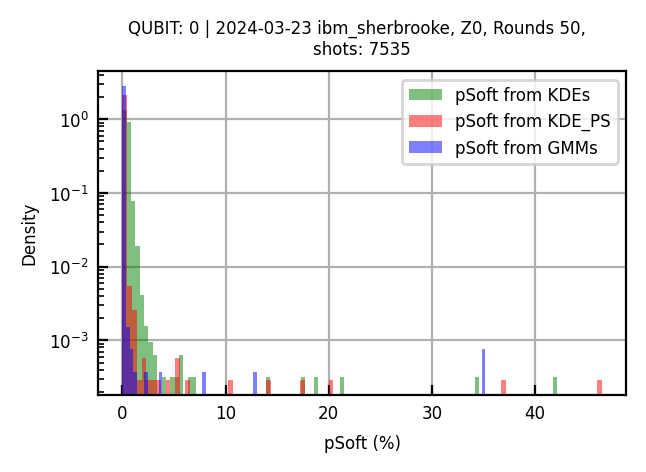

0.49370730256094225 3.3912101181641523


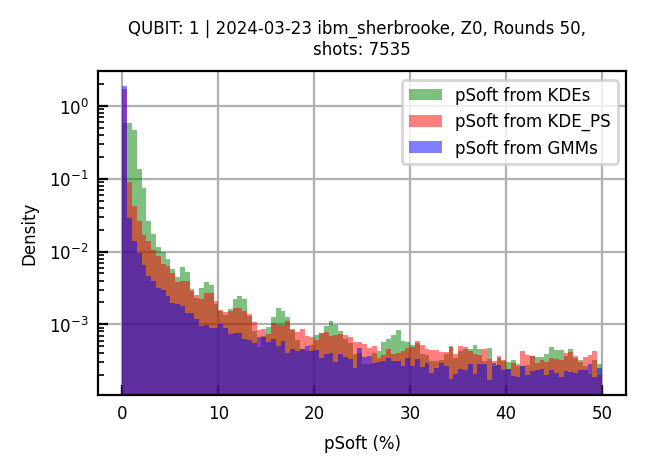

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

qubit = 6

for qubit in sorted(inverted_q_map.keys())[:2]:

    cols = inverted_q_map[qubit]

    data1 = pSoft.flatten() * 100  
    data1 = pSoft[:,cols].flatten() * 100  
    mean1 = np.mean(data1)  
    std1 = np.std(data1)  

    data2 = pSoftG.flatten() * 100 
    data2 = pSoftG[:,cols].flatten() * 100 
    mean2 = np.mean(data2)
    std2 = np.std(data2)
    print(mean2, std2)

    data3 = pSoftPS.flatten() * 100  
    data3 = pSoftPS[:,cols].flatten() * 100
    mean3 = np.mean(data3)
    std3 = np.std(data3)

    plt.figure(dpi=200)

    bins = 100
    alpha = 0.5
    density = True
    plt.hist(data1, bins=bins, density=density, alpha=alpha, color='g', label='pSoft from KDEs')
    plt.hist(data3, bins=bins, density=density, alpha=alpha, color='r', label='pSoft from KDE_PS')
    plt.hist(data2, bins=bins, density=density, alpha=alpha, color='b', label='pSoft from GMMs')  


    plt.ylabel("Density")
    plt.xlabel("pSoft (%)")
    plt.grid()

    # # Plot the means as vertical lines
    # plt.axvline(mean1, color='green', linestyle='dashed', linewidth=1, label=f'Mean: {mean1:.2f}%')
    # plt.axvline(mean3, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean3:.2f}%')
    # plt.axvline(mean2, color='blue', linestyle='dashed', linewidth=1, label=f'Mean: {mean2:.2f}%')  

    # # Plot the standard deviations as error bars
    # plt.errorbar(mean1, plt.ylim()[1] * 0.9, xerr=std1, fmt='o', color='green', capsize=5, label=f'Std: {std1:.2f}')
    # plt.errorbar(mean3, plt.ylim()[1] * 0.7, xerr=std3, fmt='o', color='red', capsize=5, label=f'Std: {std3:.2f}')
    # plt.errorbar(mean2, plt.ylim()[1] * 0.8, xerr=std2, fmt='o', color='blue', capsize=5, label=f'Std: {std2:.2f}')  

    # plt.ylim(0, 0.02)
    # plt.xlim(0, 0.15)

    plt.yscale('log')

    date_str = md.iloc[md_loc]['execution_date']
    execution_date = datetime.fromisoformat(date_str)
    formatted_date = execution_date.strftime('%Y-%m-%d')
    plt.title(f"QUBIT: {qubit} | {formatted_date} {DEVICE}, {state}, Rounds {ROUNDS},  \nshots: {memory.shape[0]}")
    plt.legend()
    plt.show()
